# Import packages

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import interp1d
from PIL import Image, ExifTags
# import datetime as dt
import pytz
from datetime import datetime as DT
import pandas as pd
from lxml import etree
from dateutil import parser

### Input variables

In [19]:
# unique to local files:
homedir = r'/Users/emilysturdivant/Desktop/uas_data'
logfile = os.path.join(homedir, 'f8.gpx')
imagefolder = os.path.join(homedir, 'f8')

# Standard:
namespace = {'def': 'http://www.topografix.com/GPX/1/1'}
tfmt_exif = '%Y:%m:%d %H:%M:%S' #2017-05-04T14:14:12-04:00
tfmt_gpx = '%Y-%m-%dT%H:%M:%S-04:00' #2017-05-04T14:14:12-04:00
iso_fmt="%Y%m%dT%H%M%SZ"

# Mission info
survey_id = '2016-010FA'
uas_id = 'u031'
fc_id = 'f04r01'

### Functions

In [20]:
def dt_to_UTCval(dtstr, fmt, local_tz='US/Eastern'):
    time = (pytz.timezone(local_tz).localize(DT.strptime(e.text, tfmt_gpx), is_dst=None)
                                .astimezone(pytz.utc)
                                .timestamp())
    return(time)

def gpx_tag_to_pdseries(tree, namespace, tag):
    elist = tree.xpath('./def:trk//def:trkpt//def:'+tag, namespaces=namespace)
    ser = pd.Series([e.text for e in elist], name=tag)
    return(ser)

### Parse GPX and extract components into dataframe

In [84]:
# Parse GPX and extract components into dataframe
tree = etree.parse(logfile)

# latitude and longitude
elist = tree.xpath('./def:trk//def:trkpt',namespaces=namespace)
gpxdf = pd.DataFrame([e.values() for e in elist], columns=['lat', 'lon'])

# all other tags
taglist = ['ele', 'ele2', 'course', 'roll', 'pitch', 'mode']
for tag in taglist:
    gpxdf = gpxdf.join(gpx_tag_to_pdseries(tree, namespace, tag))

# time
tag = 'time'
elist = tree.xpath('./def:trk//def:trkpt//def:'+tag, namespaces=namespace)
dt = [parser.parse(e.text) for e in elist] # parser will detect time zones
dtz = [dti.astimezone(pytz.utc) for dti in dt]
# dtz = [time.mktime(dti.utctimetuple()) for dti in dt]
gpxdf = gpxdf.join(pd.DataFrame({'time_utc':dtz, 'time_epoch': [t.timestamp() for t in dtz]}))
# dtz = [pytz.timezone(local_tz).localize(DT.strptime(e.text, tfmt_gpx), is_dst=None).astimezone(pytz.utc) for e in elist]
# t = [dt.timestamp() for dt in img_dt]
# gpxdf = gpxdf.join(pd.DataFrame({'time_utc':dtz, 'time_epoch': [t.timestamp() for t in dt]}))

gpxdf = gpxdf.sort_values(by='time_epoch')
gpxdf.head()

,lat,lon,ele,ele2,course,roll,pitch,mode,time_epoch,time_utc
0,36.1819669,-75.7515419,-6.01,0,0,0,0,Loiter,1.497365e+09,2017-06-13 14:38:22+00:00
1,36.1819669,-75.7515419,-6.92,0.07,0,0,0,Loiter,1.497365e+09,2017-06-13 14:38:22+00:00
2,36.1819671,-75.7515419,-6.9,0.09,42.36301,-0.2109267,1.303254,Loiter,1.497365e+09,2017-06-13 14:38:22+00:00
3,36.1819672,-75.7515419,-6.89,0.1,42.36145,-0.1979842,1.311603,Loiter,1.497365e+09,2017-06-13 14:38:23+00:00
4,36.1819673,-75.7515419,-6.89,0.1,42.36665,-0.1992989,1.30895,Loiter,1.497365e+09,2017-06-13 14:38:23+00:00


#### Export CSV

In [75]:
# Export CSV: logfile_gpx.csv stored in same folder as logfile
gpxdf.to_csv(os.path.splitext(logfile)[0]+'_gpx.csv', index=False)

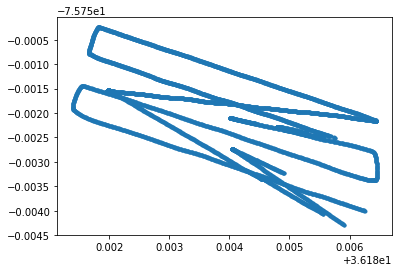

In [28]:
#%% PLOT!
plt.plot(gpxdf.lat,gpxdf.lon,'.')
plt.show()

## Work with images
Replace original images because this will consider current filenames "original" and will replace. 

In [57]:
# List all JPEGS in imagefolder
flist=[os.path.join(imagefolder,f) for f in os.listdir(imagefolder) if f.endswith('.jpg') or f.endswith('.JPG')]
print("Found {} images in {}.".format(len(flist),imagefolder))

# Get filename and DateTimeOriginal of each photo
#FIXME: how to get tzinfo from EXIF? Looks like these were recorded in UTC...
# raw_dt = [Image.open(f)._getexif()[36867] for f in flist]
dt = [DT.strptime(Image.open(f)._getexif()[36867], tfmt_exif) for f in flist]
imgdf = pd.DataFrame({'orig_name': [os.path.basename(f) for f in flist],
                      'time_utc': dt,
                      'time_epoch': [t.timestamp() for t in dt],
                      'time_iso': [t.strftime(iso_fmt) for t in dt],
                      'new_name': np.nan})
# imgdf['new_name'] = "{}_{}_{}_{}_{}".format(survey_id, uas_id, fc_id, imgdf.time_iso, imgdf.orig_name)
# dt = [parser.parse(Image.open(f)._getexif()[36867]) for f in flist] # parser changed day to 23 instead of 13
# img_dt = [dti.astimezone(pytz.utc) for dti in dt] # no need since already seems to be in UTC
# # img_dt = [(pytz.timezone(local_tz).localize(DT.strptime(Image.open(f)._getexif()[36867], tfmt_exif), is_dst=None).astimezone(pytz.utc)) for f in flist]
imgdf.head()

Found 188 images in /Users/emilysturdivant/Desktop/uas_data/f8.


,new_name,orig_name,time_epoch,time_iso,time_utc
0,NaN,B0009085.JPG,1.497379e+09,20170613T143454Z,2017-06-13 14:34:54
1,NaN,B0009130.JPG,1.497379e+09,20170613T144248Z,2017-06-13 14:42:48
2,NaN,B0009131.JPG,1.497379e+09,20170613T144250Z,2017-06-13 14:42:50
3,NaN,B0009132.JPG,1.497379e+09,20170613T144252Z,2017-06-13 14:42:52
4,NaN,B0009133.JPG,1.497379e+09,20170613T144254Z,2017-06-13 14:42:54


In [58]:
# Export CSV
imgdf.to_csv(imagefolder+'_stage1.csv', index=False)

In [85]:
# print first and last image name and times
print("First... file: {}, time: {}".format(imgdf.orig_name.iloc[0],imgdf.time_utc.iloc[0]))
print("Last... file: {}, time: {}".format(imgdf.orig_name.iloc[-1],imgdf.time_utc.iloc[-1]))
# print first and last times in .gpx file
print("{} from {} to {}".format(logfile, gpxdf.time_utc.iloc[0],gpxdf.time_utc.iloc[-1]))

First... file: B0009085.JPG, time: 2017-06-13 14:34:54
Last... file: B0009316.JPG, time: 2017-06-13 14:49:00
/Users/emilysturdivant/Desktop/uas_data/f8.gpx from 2017-06-13 14:38:22+00:00 to 2017-06-13 14:55:08+00:00


### Rename photos

In [63]:
# Rename photos
#TODO move/copy them first? / don't run if the names have already been changed...
for idx, row in imgdf.iterrows():
    img = row.orig_name
    new_name = "{}_{}_{}_{}_{}".format(survey_id, uas_id, fc_id, row.time_iso, img) # ->
    os.rename(os.path.join(imagefolder, img), os.path.join(imagefolder, new_name))
#     imgdf.new_name.loc[idx] = new_name


/Users/emilysturdivant/anaconda/envs/IOOS3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# More direct from Sherwood interp:

### Interpolation from Sherwood, modified to DF inputs

In [79]:
# Convert to NP formats and combine .gpx data into array
data = np.zeros((3,(len(gpxdf.lat))))
data[0,:]=gpxdf.lat
data[1,:]=gpxdf.lon
data[2,:]=gpxdf.ele

dn = np.array(gpxdf.time_epoch)
img_dn = np.array(imgdf.time_epoch)
img_name = np.array(imgdf.orig_name)

# set up interpolation
set_interp = interp1d(dn, data, kind='linear')

# array for storing lat, lon, and elevation for each image
img_nogps = []
img_data = np.ones((3, len(img_name)))*np.nan
for i in range(len(img_name)):
    if(img_dn[i]>=dn[0] and img_dn[i]<=dn[-1]):
        # image time is within bounds of .gpx data
        img_data[:,i] = set_interp(img_dn[i])
    else:
        # image time is not within .gpx data
        img_nogps.append(img_name[i])
        print(img_dn[i], dn[0], dn[-1])
        
print('No GPS data for {} images out of {}'.format(len(img_nogps), len(img_name)))

1497378894.0 1497364702.0 1497365708.0
1497379368.0 1497364702.0 1497365708.0
1497379370.0 1497364702.0 1497365708.0
1497379372.0 1497364702.0 1497365708.0
1497379374.0 1497364702.0 1497365708.0
1497379376.0 1497364702.0 1497365708.0
1497379378.0 1497364702.0 1497365708.0
1497379380.0 1497364702.0 1497365708.0
1497379382.0 1497364702.0 1497365708.0
1497379384.0 1497364702.0 1497365708.0
1497379386.0 1497364702.0 1497365708.0
1497379388.0 1497364702.0 1497365708.0
1497379390.0 1497364702.0 1497365708.0
1497379392.0 1497364702.0 1497365708.0
1497379394.0 1497364702.0 1497365708.0
1497379396.0 1497364702.0 1497365708.0
1497379398.0 1497364702.0 1497365708.0
1497379400.0 1497364702.0 1497365708.0
1497379402.0 1497364702.0 1497365708.0
1497379404.0 1497364702.0 1497365708.0
1497379406.0 1497364702.0 1497365708.0
1497379408.0 1497364702.0 1497365708.0
1497379410.0 1497364702.0 1497365708.0
1497379412.0 1497364702.0 1497365708.0
1497379414.0 1497364702.0 1497365708.0
1497379416.0 1497364702.0

In [71]:
# Convert to NP formats and combine .gpx data into array
data = np.zeros((3,(len(gpxdf.lat))))
data[0,:]=gpxdf.lat
data[1,:]=gpxdf.lon
data[2,:]=gpxdf.ele

dn = np.array(gpxdf.time_utc)
img_dn = np.array(imgdf.time_utc)
img_name = np.array(imgdf.orig_name)

['2017-06-13T14:34:54.000000000' '2017-06-13T14:42:48.000000000'
 '2017-06-13T14:42:50.000000000']


In [ ]:
# use where to find image times within bounds of gps times
ser = imgdf.time_utc
ser.where(ser >= start_gpxtime and ser <= start_gpxtime, np.nan)
df1 = gpxdf
df2 = imgdf
matches = df1[df1.time_epoch.isin(df2.time_epoch)] # All rows in df1 that have a match in df2.
matches.head()

In [ ]:
# test whether datetime objects can be compared successfully
start_gpxtime = gpxdf.time_utc.iloc[0]
end_gpxtime = gpxdf.time_utc.iloc[-1]
imgdf.time_utc.iloc[0]
no = imgdf.time_utc <= start_gpxtime
print(no)

In [83]:
# try loop with DF operations
start_gpxtime = gpxdf.time_epoch.iloc[0]
end_gpxtime = gpxdf.time_epoch.iloc[-1]
# gpxdf.time_utc.iloc[0],gpxdf.time_utc.iloc[-1]
# loop through the images and interpolate .gpx data
img_nogps = []
img_data = np.ones((3, len(img_name)))*np.nan
for idx, row in imgdf.iterrows():
    img_tznum = row.time_epoch
    print(img_tznum, start_gpxtime, end_gpxtime)
    if img_tznum >= start_gpxtime and img_tznum <= end_gpxtime:
        img_data[:,idx] = set_interp(img_tznum)
    else:
        # image time is not within .gpx data
        img_nogps.append(row.orig_name)
        print('Image {} not acquired between {} and {}'.format(row.orig_name, start_gpxtime, end_gpxtime))

1497378894.0 1497364702.0 1497365708.0
Image B0009085.JPG not acquired between 1497364702.0 and 1497365708.0
1497379368.0 1497364702.0 1497365708.0
Image B0009130.JPG not acquired between 1497364702.0 and 1497365708.0
1497379370.0 1497364702.0 1497365708.0
Image B0009131.JPG not acquired between 1497364702.0 and 1497365708.0
1497379372.0 1497364702.0 1497365708.0
Image B0009132.JPG not acquired between 1497364702.0 and 1497365708.0
1497379374.0 1497364702.0 1497365708.0
Image B0009133.JPG not acquired between 1497364702.0 and 1497365708.0
1497379376.0 1497364702.0 1497365708.0
Image B0009134.JPG not acquired between 1497364702.0 and 1497365708.0
1497379378.0 1497364702.0 1497365708.0
Image B0009135.JPG not acquired between 1497364702.0 and 1497365708.0
1497379380.0 1497364702.0 1497365708.0
Image B0009136.JPG not acquired between 1497364702.0 and 1497365708.0
1497379382.0 1497364702.0 1497365708.0
Image B0009137.JPG not acquired between 1497364702.0 and 1497365708.0
1497379384.0 149736

Image B0009307.JPG not acquired between 1497364702.0 and 1497365708.0
1497379724.0 1497364702.0 1497365708.0
Image B0009308.JPG not acquired between 1497364702.0 and 1497365708.0
1497379726.0 1497364702.0 1497365708.0
Image B0009309.JPG not acquired between 1497364702.0 and 1497365708.0
1497379728.0 1497364702.0 1497365708.0
Image B0009310.JPG not acquired between 1497364702.0 and 1497365708.0
1497379730.0 1497364702.0 1497365708.0
Image B0009311.JPG not acquired between 1497364702.0 and 1497365708.0
1497379732.0 1497364702.0 1497365708.0
Image B0009312.JPG not acquired between 1497364702.0 and 1497365708.0
1497379734.0 1497364702.0 1497365708.0
Image B0009313.JPG not acquired between 1497364702.0 and 1497365708.0
1497379736.0 1497364702.0 1497365708.0
Image B0009314.JPG not acquired between 1497364702.0 and 1497365708.0
1497379738.0 1497364702.0 1497365708.0
Image B0009315.JPG not acquired between 1497364702.0 and 1497365708.0
1497379740.0 1497364702.0 1497365708.0
Image B0009316.JPG 

In [ ]:
# make a bare-bones trackline and overlay image locations, sherwood direct
plt.plot(lon[:],lat[:],'-')
plt.plot(data[1,:],data[0,:],'.r')
plt.show()
# print out file name, time, and data
# TODO - write a .csv file with columns in the in the correct order for Photoscan
for i in range(10):
    print("{}, {}, {}, {}".format(img_name[i],img_dt[i],img_data[0,i],img_data[1,i],img_data[2,i]))